# Inverse design

Starting with some potential $\mathbf{\Theta}$ and stationary positions $\mathbf{X}^*_{\mathbf{\Theta}}$, we set target positions, $\mathbf{X}^*_{\mathrm{ref}}$. 

Using the implicit derivative, we will minimize the loss:

$$
L(\mathbf{\Theta}) = \frac{1}{2}\| \mathbf{X}^*_{\mathbf{\Theta}}  - \mathbf{X}^* \|^2
$$ 
with loss gradient given by:
$$\nabla_{\mathbf{\Theta}}L(\mathbf{\Theta}) = \big(\nabla_{\mathbf{\Theta}} \mathbf{X}^*_{\mathbf{\Theta}}\big)  
\big[ \mathbf{X}^*_{\mathbf{\Theta}}  - \mathbf{X}^* \big]
$$

and find the new potential parameters $\mathbf{\Theta}$, at which the system's structure is as close as possible to the target one.

## BCC vacancy inverse design example

Here, we select a simple example, where we start with a relaxed W BCC with a concentration of vacancies, $\mathbf{X}_0^*$ and some starting potential $\mathbf{\Theta}_0$. We perturb the potential, and obtain in this way the target positions $\mathbf{X}_{\mathrm{ref}}$ by minimizing the system with the perturbed potential.

Then, we perform the loss minimization starting from $\mathbf{\Theta}_0$ to obtain the target positions $\mathbf{X}_{\mathrm{ref}}$. In the folder `./run_scripts` there are realistic cases of the inverse design workflow for dislocation core reconstruction.

In [18]:
# Standard libraries
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Package imports
from lammps_implicit_der import SNAP, LammpsImplicitDer
from lammps_implicit_der.systems import BCC, BCC_BINARY, BCC_BINARY_VACANCY, BCC_VACANCY, \
                                        BCC_SIA, FromData, HCP, \
                                        BccVacancyConcentration
from lammps_implicit_der.tools import plot_tools, error_tools

# No parallel MPI runs in the notebook, but keep comm for consistency
comm = None

# For parallel runs, use the following:
# from lammps_implicit_der.tools import mpi_print, initialize_mpi
# comm, rank = initialize_mpi()

In [2]:
ncell_x = 2
vac_conc = 0.3
alat = 3.18

# Create a BCC system with vacancies
bcc_vac_conc0 = BccVacancyConcentration(alat=alat, ncell_x=ncell_x, minimize=True,
                                        vac_conc=vac_conc, verbose=False,
                                        snapcoeff_filename='W_REF.snapcoeff', comm=comm)

In [3]:
# Read the potential ensemble
with open('Theta_ens.pkl', 'rb') as f:
    Theta_ens = pickle.load(f)

# Create one strongly perturbed potential
delta = 5.0
sample = 1
Theta_perturb = Theta_ens['Theta_mean'] + delta * (Theta_ens['Theta_ens_list'][sample] - Theta_ens['Theta_mean'])

# Save the perturbed potential to files
pot = SNAP.from_files(snapcoeff_filename='W_REF.snapcoeff', snapparam_filename='W_REF.snapparam')
pot.Theta_dict['W']['Theta'] = Theta_perturb.copy()
pot.to_files(snapcoeff_filename='W_perturb.snapcoeff', snapparam_filename='W_perturb.snapparam',
             overwrite=True, verbose=False)

# Create a new LAMMPS object with the perturbed potential
bcc_vac_conc_perturb = BccVacancyConcentration(alat=alat, ncell_x=ncell_x,
                                               minimize=True, vac_conc=vac_conc,
                                               verbose=False,
                                               snapcoeff_filename='W_perturb.snapcoeff',
                                               data_path='.', comm=comm)

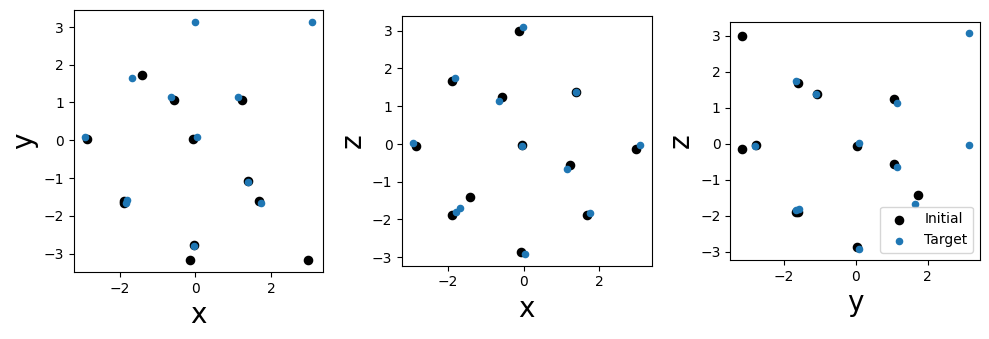

In [4]:
# Initial and target positions
#X_initial = vac0.X_coord.copy()
#X_target = vac_perturb.X_coord.copy()

X_initial = bcc_vac_conc0.X_coord.copy()
X_target = bcc_vac_conc_perturb.X_coord.copy()

Theta_initial = bcc_vac_conc0.pot.Theta_dict['W']['Theta'].copy()

# Plot the initial and target positions
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
plot_tools.plot_coords(axes,X_initial.reshape(-1, 3), s=35, color='black', label='Initial')
plot_tools.plot_coords(axes, X_target.reshape(-1, 3), s=20, label='Target')
plt.tight_layout()
plt.show()

## Loss minimization

In [5]:
# Print the docstring of the minimize_loss function
# for more information on the arguments
print(error_tools.minimize_loss.__doc__)


    Optimize the potential parameters to get the X_target
    as stationary point of the potential.

    This is done using the gradient descent method of
    minimizing the loss function:

    .. math::
        L(\Theta) = 1/2 (X(\Theta) - X_{target})^2

    Parameters
    ----------

    sim : simulation object
        Instance of the LammpsImplicitDer class (child classes: BCC_VACANCY, DISLO, ...), with initial positions.

    X_target : numpy array
        Target positions. Shape: (Natoms, 3).

    sub_element : str
        Element name for which the potential parameters will be optimized.

    der_method : str, optional
        Method to compute the inhomogeneous implicit derivative.

    der_min_style : str, optional
        LAMMPS minimization style for the implicit derivative (for the 'energy' method only).

    der_adaptive_alpha : bool, optional
        Adaptive scaling factor alpha0 for implicit derivative calculation with sparse and energy methods.

    der_alpha0 : float,

In [6]:
bcc_vac_conc_final, minim_dict = error_tools.minimize_loss(
                                          bcc_vac_conc0,
                                          X_target,
                                          'W',
                                          maxiter=10,
                                          adaptive_step=True,
                                          error_tol=1e-4,
                                          der_method='dense',
                                          verbosity=2,
                                          minimize_at_iters=False,
                                          comm=comm,
                                          )


=======================Running the parameter optimization=======================

Using adaptive step size. fixed_step will be ignored
                 Initial error: 1.647e-01

Iteration 1 / 10
Computing dX/dTheta using dense method.

  >>Updating the potential parameters for W


           -------------Errors-------------
                 Current error: 4.359e-02
                  Error change: 1.211e-01
Iteration 2 / 10
Computing dX/dTheta using dense method.

  >>Updating the potential parameters for W


           -------------Errors-------------
                 Current error: 2.892e-02
                  Error change: 1.467e-02
Iteration 3 / 10
Computing dX/dTheta using dense method.

  >>Updating the potential parameters for W


           -------------Errors-------------
                 Current error: 2.367e-02
                  Error change: 5.253e-03
Iteration 4 / 10
Computing dX/dTheta using dense method.

  >>Updating the potential parameters for W


           ----------

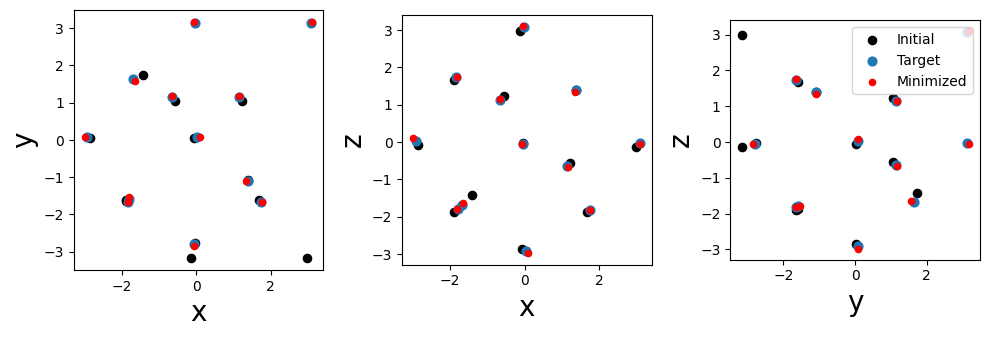

In [7]:
X_final = bcc_vac_conc_final.X_coord.copy()
Theta_final = bcc_vac_conc_final.pot.Theta_dict['W']['Theta'].copy()

# Plot the initial, target and minimized positions
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
plot_tools.plot_coords(axes,X_initial.reshape(-1, 3), s=35, color='black', label='Initial')
plot_tools.plot_coords(axes, X_target.reshape(-1, 3), s=40, label='Target')
plot_tools.plot_coords(axes, X_final.reshape(-1, 3), color='red', s=20, label='Minimized')
plt.tight_layout()
plt.show()

## Plot minimization results

### Coordinate errors during minimization

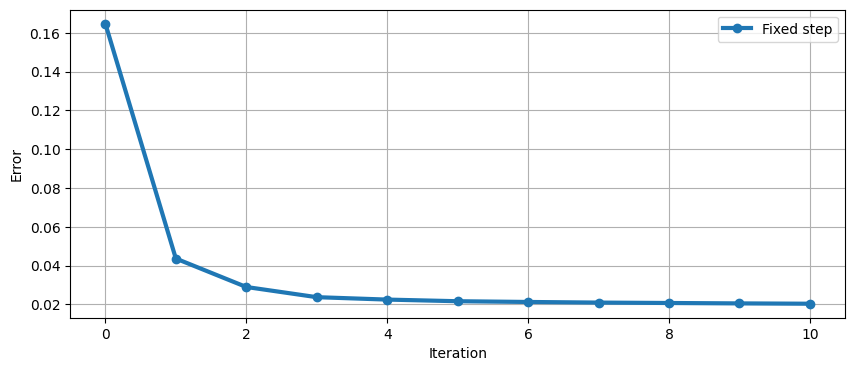

In [8]:
error_array = minim_dict['error_array']

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(error_array, label='Fixed step', marker='o', lw=3)
ax.set_xlabel('Iteration')
ax.set_ylabel('Error')
ax.grid()
ax.legend()
plt.show()


### Adaptive step size

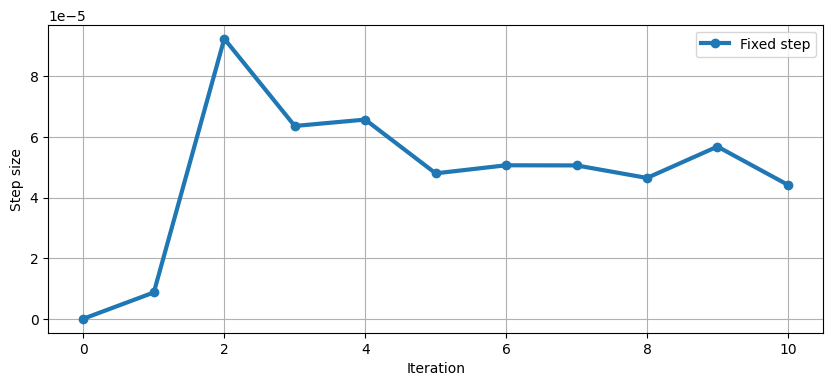

In [9]:
step_array = minim_dict['step_array']

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(step_array, label='Fixed step', marker='o', lw=3)
ax.set_xlabel('Iteration')
ax.set_ylabel('Step size')
ax.grid()
ax.legend()
plt.show()

## Potential for initial, target and minimized systems

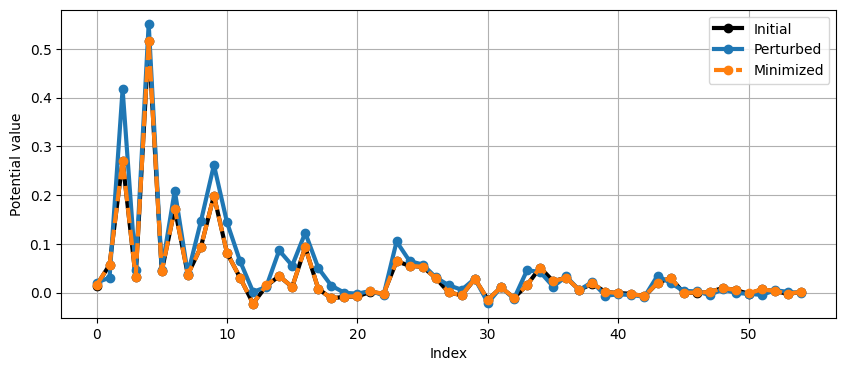

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

ax.plot(Theta_initial, label='Initial', marker='o', lw=3, color='black')
ax.plot(Theta_perturb, label='Perturbed', marker='o', lw=3)
ax.plot(Theta_final, label='Minimized', marker='o', lw=3, ls='--')
ax.set_xlabel('Index')
ax.set_ylabel('Potential value')
ax.grid()
ax.legend()
plt.show()

### Minimal difference between the initial and minimized potential is enough to produce a structure obtained with a strongly perturbed potential

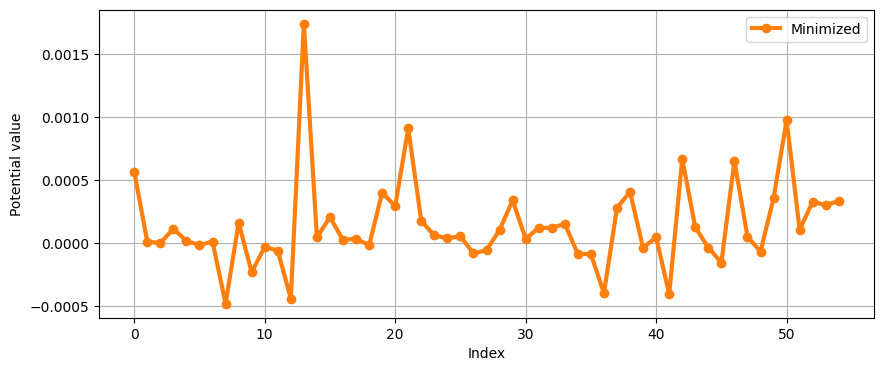

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

ax.plot(Theta_final-Theta_initial, label='Minimized', marker='o', lw=3, ls='-', color='tab:orange')
ax.set_xlabel('Index')
ax.set_ylabel('Potential value')
ax.grid()
ax.legend()
plt.show()